## Group 19
### HA2 - Mining frequent itemsets

Cátia Antunes (60494) -<br>Donato Aveiro (46269) - 15h<br>Márcia Vital (59488) - 15h<br>Sean Gorman (59492) -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder
from PD_freqitems import freqitemsets
from pyfim import pyeclat

### Data preprocessing

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

del products[0] #the products list contains a 0 as the first element
#products

In [3]:
#Read transactions
orders=pickle.load(open("order_products.pickle", "rb"))

In [4]:
#Check products on order 2:
#for prod in orders[2]: print(products[prod])

In [4]:
#Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]
#orders_list

In [5]:
#Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df

In [6]:
df.columns = [prod_dict[str(key)] for key in df.columns]
#df

### Objective 1 - Analyze the itemset/rules generation procedure

In [7]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(df, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(df, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(orders_list, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(orders_list, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    

df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 6.503108978271484 
	FP-growth time: 25.998323440551758 
	ECLAT time: 134.19745230674744 
	PD time: 62.2296416759491
0.1 2 
	Apriori time: 7.131574869155884 
	FP-growth time: 26.438154935836792 
	ECLAT time: 149.50398135185242 
	PD time: 84.78894186019897
0.05 6 
	Apriori time: 7.409392833709717 
	FP-growth time: 30.28647756576538 
	ECLAT time: 174.02131533622742 
	PD time: 68.09205102920532
0.02 39 
	Apriori time: 64.30059242248535 
	FP-growth time: 44.031718254089355 
	ECLAT time: 103.13330006599426 
	PD time: 68.21316075325012


C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


0.01 102 
	Apriori time: 146.0393328666687 
	FP-growth time: 67.44478416442871 
	ECLAT time: 112.22292947769165 
	PD time: 90.13535237312317


,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.20,0,6.503109,25.998323,134.197452,62.229642
1,0.10,2,7.131575,26.438155,149.503981,84.788942
2,0.05,6,7.409393,30.286478,174.021315,68.092051
3,0.02,39,64.300592,44.031718,103.133300,68.213161
4,0.01,102,146.039333,67.444784,112.222929,90.135352


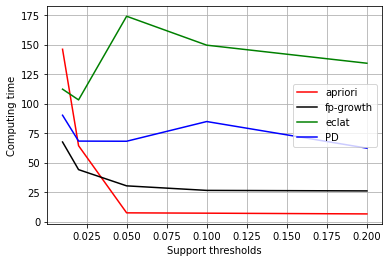

In [8]:
plt.plot(df_performance["threshold"], df_performance["apriori"], c='r', label='apriori')
plt.plot(df_performance["threshold"], df_performance["FP-growth"], c='k', label='fp-growth')
plt.plot(df_performance["threshold"], df_performance["ECLAT"], c='g', label='eclat')
plt.plot(df_performance["threshold"], df_performance["PD"], c='b', label='PD')
plt.xlabel("Support thresholds")
plt.ylabel("Computing time")
plt.grid()
plt.legend()
plt.show()

Although the apriori algorithm has the best performance for higher support thresholds, it is quickly outperformed by all the other algorithms for lower support thresholds. 

ECLAT is clearly the worst algorithm in general, which is surprising, since it supposedly scales well for large datasets.

FP-growth is the best-performing algorithm for lower support thresholds. Thus, from now on we will be using FP-growth.

### Objective 2 - Identify the most relevant rules


Let's now generate the itemsets with support = 0.02 and support = 0.01 and compare them:

In [13]:
def get_itemsets_counts(binary_df, support_list):
    for support in support_list:
        support_df = fpgrowth(binary_df, min_support=support,use_colnames=True)
        support_df['length'] = support_df['itemsets'].apply(lambda x: len(x))
        itemsets_count = list(support_df['length'].value_counts())
        print('\nSupport = {}:'.format(support))
        for i in range(1, len(itemsets_count)+1):
            print('{} {}-itemsets'.format(itemsets_count[i-1], i))

In [14]:
get_itemsets_counts(df, [0.02, 0.01])


Support = 0.02:
39 1-itemsets

Support = 0.01:
102 1-itemsets
14 2-itemsets


There are no 2-itemsets for FP-growth when support = 0.02, in contrast to when support = 0.01. Therefore, we will continue our analysis with support = 0.01, otherwise we will not be able to generate association rules.

In [15]:
FI_fpgrowth = fpgrowth(df, min_support=0.01, use_colnames=True)
FI_fpgrowth['length'] = FI_fpgrowth['itemsets'].apply(lambda x: len(x))
FI_fpgrowth.sort_values(by=['length'], ascending=False)
FI_fpgrowth[FI_fpgrowth['length'] == 2]

,support,itemsets,length
102,0.015987,"(Organic Baby Spinach, Banana)",2
103,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
104,0.015668,"(Organic Baby Spinach, Bag of Organic Bananas)",2
105,0.019391,"(Organic Hass Avocado, Bag of Organic Bananas)",2
106,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
107,0.012689,"(Organic Hass Avocado, Organic Strawberries)",2
108,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
109,0.010533,"(Organic Strawberries, Organic Raspberries)",2
110,0.017468,"(Organic Strawberries, Banana)",2
111,0.019170,"(Organic Strawberries, Bag of Organic Bananas)",2


At a first glance, these 2-itemsets seem to make sense - different kinds of fruits are frequently bought together in real life, as well as fruits and vegetables.

Let's check all the rules and choose a set that seems relevant:

In [16]:
all_rules = association_rules(FI_fpgrowth, metric="support", min_threshold=0.01)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Baby Spinach),(Banana),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
1,(Banana),(Organic Baby Spinach),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180
2,(Organic Baby Spinach),(Organic Strawberries),0.075251,0.082331,0.011862,0.157630,1.914594,0.005666,1.089390,0.516568
3,(Organic Strawberries),(Organic Baby Spinach),0.082331,0.075251,0.011862,0.144074,1.914594,0.005666,1.080408,0.520554
4,(Organic Baby Spinach),(Bag of Organic Bananas),0.075251,0.118030,0.015668,0.208217,1.764107,0.006787,1.113904,0.468388
5,(Bag of Organic Bananas),(Organic Baby Spinach),0.118030,0.075251,0.015668,0.132750,1.764107,0.006787,1.066301,0.491106
6,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
7,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
8,(Organic Baby Spinach),(Organic Hass Avocado),0.075251,0.066436,0.010856,0.144266,2.171499,0.005857,1.090951,0.583389
9,(Organic Hass Avocado),(Organic Baby Spinach),0.066436,0.075251,0.010856,0.163406,2.171499,0.005857,1.105375,0.577881


The conviction values do not seem to change much from rule to rule, with the majority having a value less than 1.2 and all having a value greater than 1, which indicates that the presence of the antecedent has a positive effect on the occurence of the consequent for all rules. As such, we will not focus too much on this metric. Likewise, as defined in Objective 1, the support values are all between 0.01 and 0.02, which means that this metric will not be as appropriate to compare rules as lift and confidence, as we know that for every rule the antecedent and the consequent appear together in 1% of all transactions.

There seems to be a greater range of values for the lift metric, with some rules having a lift value that is twice the value of others. Let's check the ones with lift >= 2.5.

In [17]:
all_rules = association_rules(FI_fpgrowth, metric="lift", min_threshold=2.5)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
1,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
2,(Organic Strawberries),(Organic Raspberries),0.082331,0.042632,0.010533,0.127938,3.000973,0.007023,1.097821,0.726596
3,(Organic Raspberries),(Organic Strawberries),0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801,0.696467
4,(Organic Fuji Apple),(Banana),0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923,0.629388
5,(Banana),(Organic Fuji Apple),0.146993,0.027880,0.010558,0.071827,2.576259,0.006460,1.047348,0.717275


Of these rules with a large lift value, three seem the most relevant as they have a much greater confidence compared to the other ones. These are: 

(Organic Raspberries) => (Bag of Organic Bananas) (confidence = 0.30, lift = 2.50)

(Organic Raspberries) => (Organic Strawberries) (confidence = 0.25, lift = 3.00)

(Organic Fuji Apple) => (Banana) (confidence = 0.38, lift = 2.58)

For example, for this last rule, we can say that 38% of the transactions that contain Organic Fuji Apple also contain Banana, and the probability of Banana being purchased when Organic Fuji Apple is purchased is 2.58 times higher than the probability of Banana being purchased in general. There is a non-random relationship between these two products.

The same logic can be applied to the other rules.

Now, let's identify the maximal itemsets for 2-itemsets with support = 0.01:

In [18]:
FI_fpmax = fpmax(df, min_support=0.01, use_colnames=True)
FI_fpmax['length'] = FI_fpmax['itemsets'].apply(lambda x: len(x))
FI_fpmax.sort_values(by=['length'], ascending=False)
FI_fpmax[FI_fpmax['length'] >= 2]

,support,itemsets,length
85,0.010558,"(Organic Fuji Apple, Banana)",2
91,0.010533,"(Organic Strawberries, Organic Raspberries)",2
92,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
95,0.012825,"(Banana, Strawberries)",2
96,0.012716,"(Large Lemon, Banana)",2
97,0.016609,"(Banana, Organic Avocado)",2
98,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
99,0.012689,"(Organic Hass Avocado, Organic Strawberries)",2
100,0.019391,"(Organic Hass Avocado, Bag of Organic Bananas)",2
101,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2


## to finish

#### Identify the Maximal and Closed Itemsets for the same level of support (maximal is done)
#### [challenging] Generate the most relevant rules for closed and maximal itemsets with adequate statistics (support, confidence, lift and conviction) and discuss your findings

In [19]:
frequent = fpgrowth(df, min_support=0.01, use_colnames=True)
su = frequent.support.unique() #all unique support count

#Dictionary storing itemsets with the same support count key
fredic = {}
for i in range(len(su)):
    inset = list(frequent.loc[frequent.support ==su[i]]['itemsets'])
    fredic[su[i]] = inset

#Dictionary storing itemsets with support count <= key
fredic2 = {}
for i in range(len(su)):
    inset2 = list(frequent.loc[frequent.support<=su[i]]['itemsets'])
    fredic2[su[i]] = inset2

#Find closed frequent itemsets with length >= 2
closed_itemsets = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic[cls]
    
    #Only include closed frequent itemsets with length >= 2
    if len(cli) < 2:
        continue
    
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        closed_itemsets.append({'support': cls, 'itemsets': cli})

#Create dataframe with closed frequent itemsets and length column
closed_itemsets_df = pd.DataFrame(closed_itemsets)
closed_itemsets_df['length'] = closed_itemsets_df['itemsets'].apply(lambda x: len(x))
closed_itemsets_df

,support,itemsets,length
0,0.015987,"(Organic Baby Spinach, Banana)",2
1,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
2,0.015668,"(Organic Baby Spinach, Bag of Organic Bananas)",2
3,0.019391,"(Organic Hass Avocado, Bag of Organic Bananas)",2
4,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
5,0.012689,"(Organic Hass Avocado, Organic Strawberries)",2
6,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
7,0.010533,"(Organic Strawberries, Organic Raspberries)",2
8,0.017468,"(Organic Strawberries, Banana)",2
9,0.019170,"(Organic Strawberries, Bag of Organic Bananas)",2


In [20]:
#Find maximal frequent itemsets
min_len = 2
ml = []
for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    if len(cli) < min_len:
        continue
    cls = row['support']
    checkset = fredic2[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        ml.append([cls, cli])

ml_df = pd.DataFrame(ml, columns=['support', 'itemsets'])
ml_df['length'] = ml_df['itemsets'].apply(lambda x: len(x))
ml_df

,support,itemsets,length
0,0.015987,"(Organic Baby Spinach, Banana)",2
1,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
2,0.015668,"(Organic Baby Spinach, Bag of Organic Bananas)",2
3,0.019391,"(Organic Hass Avocado, Bag of Organic Bananas)",2
4,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
5,0.012689,"(Organic Hass Avocado, Organic Strawberries)",2
6,0.012599,"(Organic Raspberries, Bag of Organic Bananas)",2
7,0.010533,"(Organic Strawberries, Organic Raspberries)",2
8,0.017468,"(Organic Strawberries, Banana)",2
9,0.019170,"(Organic Strawberries, Bag of Organic Bananas)",2


In [22]:
print(FI_fpmax['itemsets'].tolist() == closed_itemsets_df['itemsets'].tolist())
print(FI_fpmax['itemsets'].tolist() == ml_df['itemsets'].tolist())

False
False


The closed and maximal itemsets are different from the frequent itemsets.

In [23]:
print(closed_itemsets_df['itemsets'].tolist() == ml_df['itemsets'].tolist())

True


However, the closed and maximal itemsets are the same.